In [5]:
# import libraries
import numpy as np
import glob, os
import torch
import arff

# Logistic Regression for emobase arff files

In [12]:
from sklearn.linear_model import LogisticRegression
logisticRegr = LogisticRegression()
trainX, trainY = getData('arff', 'emobase_2010-train.arff')
# print trainX
testX, testY = getData('arff', 'emobase_2010-test.arff')
logisticRegr.fit(trainX, trainY)
predictions = logisticRegr.predict(testX)
# Use score method to get accuracy of model
score = logisticRegr.score(testX, testY)
print(score)


0.575757575758


1.67


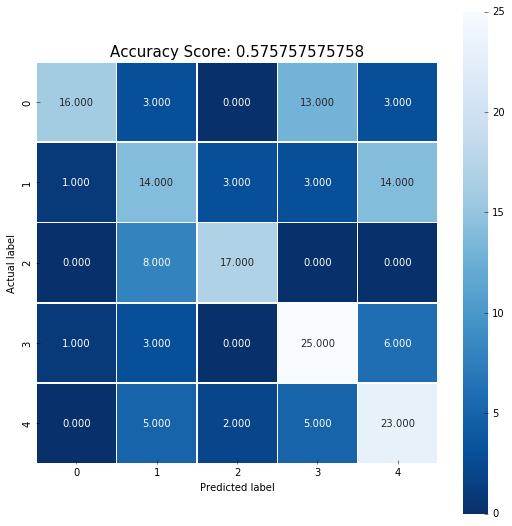

In [9]:
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 15);

# Main using csvs in train and test

In [3]:
def getData(filetype, location):
    os.chdir('/Users/jonahbolotin/Documents/Senior/Spring/Linguistics/emotion-speech-recognizer')
    if filetype == 'csv':
        truth_values, file_names = get_file_information(location)
        matrix = process_data(file_names)
    elif filetype == 'arff':
        class_mapper = {'anger': 0,
                'sadness': 1,
                'neutral': 2,
                'happiness': 3,
                'despair': 4}
        data = arff.load(open(location, 'rb'))
        matrix = np.array(data['data'])
        truth_values = matrix[:,0]
        for i,value in enumerate(truth_values):
            value = value[value.rfind('/') + 1:]
            truth_values[i] = class_mapper[value]
        matrix = np.delete(matrix, 0, 1)
        matrix = np.delete(matrix, len(matrix[0]) - 1, 1)
    return matrix.astype(float), truth_values.astype(int)
    

In [3]:
trainX, trainY = getData('csv', '/train')

NameError: global name 'get_file_information' is not defined

In [4]:
trainX[0][0]

NameError: name 'trainX' is not defined

In [5]:
len(testX[1][0])

NameError: name 'testX' is not defined

In [6]:
testX, testY = getData('csv', '/test') 

NameError: global name 'get_file_information' is not defined

In [7]:
len(trainX[1][0])

NameError: name 'trainX' is not defined

In [8]:
def numpy_to_torch(array):
    return torch.from_numpy(array)

# Get all file names

In [9]:
#sample is either '/train' or '/test'
def get_file_information(sample):
    class_mapper = {'anger': 0,
                    'sadness': 1,
                    'neutral': 2,
                    'happiness': 3,
                    'despair': 4}
    truth_values = []
    file_names = []
    base_directory = os.getcwd() + sample
    subdirectories = ['anger', 'despair', 'happiness', 'neutral', 'sadness']
    for directory in subdirectories:
        os.chdir(base_directory + '/' + directory)
        for file_name in glob.glob("*.csv"):
            truth_values.append(class_mapper[directory])
            file_names.append(os.getcwd() + '/' + file_name)
    return truth_values, file_names

# Load data into numpy

In [11]:
# Load CSV and return np.ndarray
def csv_to_numpy(filename):
    raw_data = open(filename, 'rt')
    data = np.loadtxt(raw_data, delimiter=";",skiprows=1)
#     print data
#     data = data[2:]
#     data = np.delete(data, np.s_[:2], 0)
#     print data
    return data


# Delete rows beyond 140 or add extra rows if not 140 length

In [11]:
# Need standard length for file for matrix
# Returns flattened array for big matrix
def format_np_and_flatten(data):
    num_rows = data.shape[0]
    if num_rows > 140: # delete rows
        data = np.delete(data, slice(140,num_rows), axis=0)
    else: # add rows of zeros
        num_rows_to_add = 140 - num_rows
        rows = np.zeros((num_rows_to_add, data.shape[1]))
        data = np.append(data, rows, axis=0)
    return data

# Process data

In [16]:
def process_data(file_names):
    training_matrix = []
    for filename in file_names:
        data = csv_to_numpy(filename)
#         data = format_np_and_flatten(data)
        training_matrix.append(data)
    return training_matrix

In [233]:
import torch
from torch.utils.data import Dataset, DataLoader

class MyDataset(Dataset):
    def __init__(self, x, y, transform=None):
        """
        Args:
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.x = torch.tensor(x, dtype=torch.float)
        self.y = torch.tensor(y)
        self.transform = transform

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        sample = (self.x[idx], self.y[idx])
        return sample

In [234]:
train_loader = DataLoader(MyDataset(trainX, trainY), batch_size=32, shuffle=True)
test_loader = DataLoader(MyDataset(testX, testY), batch_size=32, shuffle=True)

In [236]:
import torch
import torch.nn as nn
import numpy as np

time_steps = 2
batch_size = 590 # this is # files you're loading
input_size = 1582 # this is # of features extracted
hidden_size = 100
nclasses = 5

# define model class
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        # "nn.Linear" performs the last step of prediction, where it maps the hidden layer to # classes
        self.fc = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        # Set initial hidden and cell states 
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size) 
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        
        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))  # out: tensor of shape (batch_size, seq_length, hidden_size)
        
        # Decode the hidden state of the last time step
        out = self.fc(out[:, -1, :])
        return out

# set up model
model = RNN(input_size, hidden_size, 1, nclasses)
# defines optimization function (this is using stochastic gradient descent)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01) #, momentum=0.9
# defines loss function
criterion = nn.CrossEntropyLoss()

# say your input array looks like this (represents 2 files, each of which stores 3 features over 2 timesteps:
# trainX = [
#     [[1, 2, 3], [3, 2, 1]],
#     [[1, 3, 2], [0, 3, 3]]
# ]

# # say the true emotion classes are this
# trainY = [1, 3]

# testX = [[[2, 2, 2], [3, 0, 1]]]
# testY = [4]

# Train model
print("Training")
for epoch in range(50):
    total_loss = 0
    correct = 0
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
#         x = torch.tensor(trainX[i], dtype=torch.float).unsqueeze(0)
#         y = torch.tensor(trainY[i]).unsqueeze(0)
        # Step 3. Run our forward pass.
        outputs = model(data)
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == target).sum().item()

        # Step 4. Compute the loss, gradients, and update the parameters by
        #  calling optimizer.step()
        loss = criterion(outputs, target)
        total_loss += loss.item()

        # clear gradient for next step of training
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if batch_idx % 10 == 0:
            print("Step %d / %d, Loss: %f" % (batch_idx, len(train_loader), loss.item()))
    total_loss /= float(len(train_loader))
    correct /= float(len(trainX))
    print("Epoch #%d, Loss: %f, Accuracy: %f" % (epoch, total_loss, correct))

    model.eval()
    # Test model
    with torch.no_grad():
        correct = 0
        total = 0
        for batch_idx, (data, target) in enumerate(test_loader):
    #         x = torch.tensor(testX[i], dtype=torch.float).unsqueeze(0)
    #         y = torch.tensor(testY[i]).unsqueeze(0)

            outputs = model(data)
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == target).sum().item()
            total += len(target)

        print('Test Accuracy of the model: {} %'.format(100 * correct / total)) 


Training
Step 0 / 19, Loss: 1.589834
Step 10 / 19, Loss: 1.587790
Epoch #0, Loss: 1.582632, Accuracy: 0.240678
Test Accuracy of the model: 25 %
Step 0 / 19, Loss: 1.531542
Step 10 / 19, Loss: 1.544074
Epoch #1, Loss: 1.548695, Accuracy: 0.305085
Test Accuracy of the model: 27 %
Step 0 / 19, Loss: 1.569805
Step 10 / 19, Loss: 1.542206
Epoch #2, Loss: 1.537828, Accuracy: 0.306780
Test Accuracy of the model: 27 %
Step 0 / 19, Loss: 1.502295
Step 10 / 19, Loss: 1.623354
Epoch #3, Loss: 1.530101, Accuracy: 0.300000
Test Accuracy of the model: 27 %
Step 0 / 19, Loss: 1.488401
Step 10 / 19, Loss: 1.470379
Epoch #4, Loss: 1.519398, Accuracy: 0.300000
Test Accuracy of the model: 26 %
Step 0 / 19, Loss: 1.495625
Step 10 / 19, Loss: 1.498492
Epoch #5, Loss: 1.514701, Accuracy: 0.301695
Test Accuracy of the model: 26 %
Step 0 / 19, Loss: 1.459061
Step 10 / 19, Loss: 1.439324
Epoch #6, Loss: 1.510725, Accuracy: 0.337288
Test Accuracy of the model: 29 %
Step 0 / 19, Loss: 1.464067
Step 10 / 19, Loss

KeyboardInterrupt: 

correct

In [151]:
# Test model
with torch.no_grad():
    correct = 0
    total = 0
    for i in range(len(testX)):
        x = torch.tensor(testX[i], dtype=torch.float).unsqueeze(0)
        y = torch.tensor(testY[i]).unsqueeze(0)

        outputs = model(x)
        _, predicted = torch.max(outputs.data, 1)
        total += y.size(0)
        if predicted == y:
            correct += 1

    print('Test Accuracy of the model: {} %'.format(100 * correct / total)) 

RuntimeError: input.size(-1) must be equal to input_size. Expected 1582, got 13

# Create charts for paper

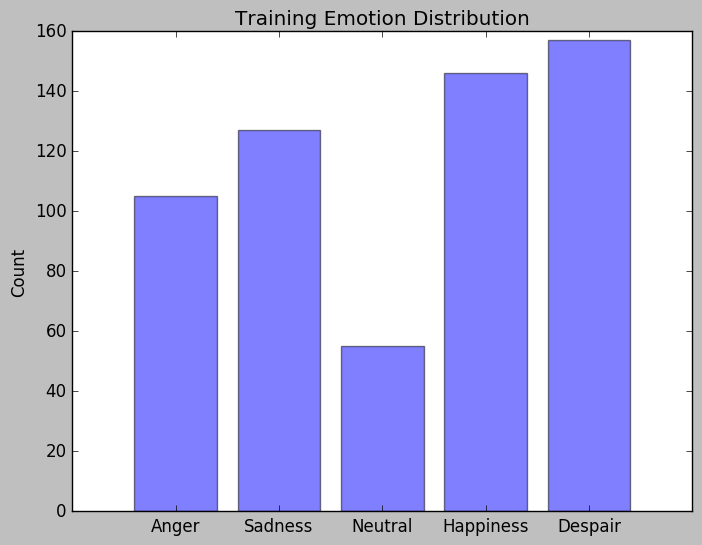

In [13]:
%matplotlib inline

# class_mapper = {'anger': 0,
#                 'sadness': 1,
#                 'neutral': 2,
#                 'happiness': 3,
#                 'despair': 4}
truth_values = []
file_names = []
os.chdir('/Users/jonahbolotin/Documents/Senior/Spring/Linguistics/emotion-speech-recognizer')

base_directory = os.getcwd() + '/train'
subdirectories = ['anger', 'despair', 'happiness', 'neutral', 'sadness']
for directory in subdirectories:
    os.chdir(base_directory + '/' + directory)
    for file_name in glob.glob("*.csv"):
        truth_values.append(directory)

import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt
 
objects = ('Anger', 'Sadness', 'Neutral', 'Happiness', 'Despair')
y_pos = np.arange(len(objects))
performance = [truth_values.count('anger'),truth_values.count('sadness'),truth_values.count('neutral'),truth_values.count('happiness'),truth_values.count('despair')]
 
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Count')
plt.title('Training Emotion Distribution')
 
plt.show()

In [9]:
len(truth_values)

590